# **Introduction**

## Weekend Rainfall Analysis in Buenos Aires (2020–2025)

### This notebook investigates a common belief:  
### "It rains more on weekends"

### Using daily precipitation data from the Buenos Aires Central Observatory, we aim to answer:

### 1. Does daily precipitation (mm/day) differ between weekdays and weekends?
### 2. Is the probability of rainfall different between the two?

Load and prepare data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm


### Load of 'export' dataset, downloaded from meteostat.net under the following parameters: 
### **Observatory:** Buenos Aires Central Observatory
### **Date range:** 13/11/2020 - 13/11/2025

### Field information:
date (YYYY-mm-dd)

tavg: average Temperature (°C)

tmin: minimum temperature (°C)

tmax: maximum temperature (°C)

prcp: total precipitation (mm)

snow: snow depth 

wdir: wind (From) direction (°)

wspd: wind speed (km/h)

wpgt: wind peak gust (km/h)

pres: sea-level air pressure (hPa)

tsun: total sunshine duration (minutes)

In [ ]:
df = pd.read_csv('export.csv')
df['date'] = pd.to_datetime(df['date'], origin='1899-12-30', unit='D')
df.head()



,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-11-13,22.2,19.2,26.6,NaN,NaN,NaN,9.0,NaN,1013.1,NaN
1,2020-11-14,22.2,19.3,26.6,NaN,NaN,NaN,4.0,NaN,1010.3,NaN
2,2020-11-15,20.9,15.7,26.0,NaN,NaN,NaN,11.1,NaN,1013.5,NaN
3,2020-11-16,20.5,14.0,26.3,NaN,NaN,NaN,6.8,NaN,1014.6,NaN
4,2020-11-17,23.4,17.7,27.7,NaN,NaN,NaN,8.2,NaN,1013.0,NaN


In [483]:
print('\nStatistical description of data:\n')
print(df.describe(include='all'))


Statistical description of data:

                                date         tavg         tmin         tmax  \
count                           1827  1827.000000  1827.000000  1827.000000   
mean   2023-05-14 23:59:59.999999744    18.746196    14.418993    24.374330   
min              2020-11-13 00:00:00     3.700000    -1.900000     9.200000   
25%              2022-02-12 12:00:00    14.100000     9.800000    19.400000   
50%              2023-05-15 00:00:00    18.900000    14.600000    24.400000   
75%              2024-08-13 12:00:00    23.400000    19.100000    29.400000   
max              2025-11-13 00:00:00    33.500000    29.800000    41.500000   
std                              NaN     5.840665     5.899633     6.260565   

              prcp      snow  wdir         wspd  wpgt         pres  tsun  
count  1318.000000  5.000000   0.0  1827.000000   0.0  1827.000000   0.0  
mean      3.986419  2.800000   NaN     8.743733   NaN  1015.985495   NaN  
min       0.000000  1.000000


Missing values by field:

date       0
tavg       0
tmin       0
tmax       0
prcp     509
snow    1822
wdir    1827
wspd       0
wpgt    1827
pres       0
tsun    1827
dtype: int64


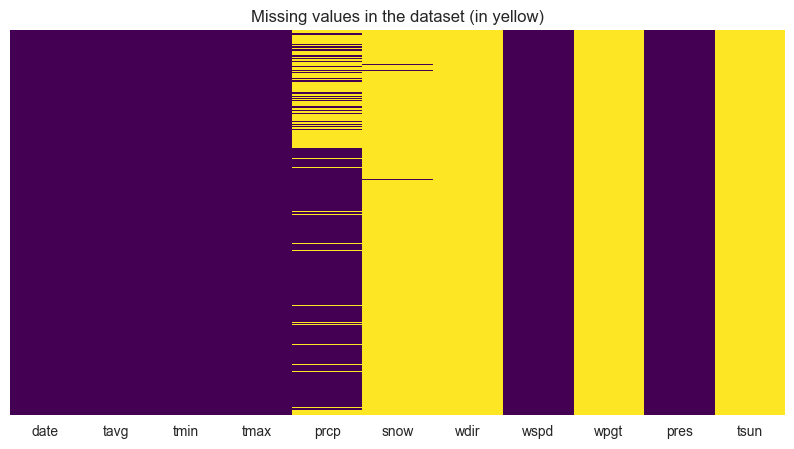

In [484]:
print('\nMissing values by field:\n')
print(df.isna().sum())

plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing values in the dataset (in yellow)')
plt.show()

## Dataset cleaning

Are there fields that should be eliminated?

-wdir, wpgt and tsun have no non-null values.

-in wspd, snow and pres, the non-null values represent more than 60% of the total and do not contribute relevance to the pertinent analysis.

In [ ]:
cols_to_drop=['snow', 'wdir','wspd','wpgt', 'pres','tsun']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

df.head()

,date,tavg,tmin,tmax,prcp
0,2020-11-13,22.2,19.2,26.6,NaN
1,2020-11-14,22.2,19.3,26.6,NaN
2,2020-11-15,20.9,15.7,26.0,NaN
3,2020-11-16,20.5,14.0,26.3,NaN
4,2020-11-17,23.4,17.7,27.7,NaN


## Null value handling

Upon reaching our main field of interest (precipitation), we see that there is a high number of null values.

Are they mostly corresponding to days without rain or they have missing data for analysis?

To determine it, the daily precipitation is grouped by year (2021-2024) and contrasted with yearly-summarized data from the National Meteorologycal Service (OCBA-SMN)

In [ ]:
#Dataset preparation with daily records. Creation of columns 'year' and 'rainy_day' (boolean value, True for days with precipitation)

df['year'] =df['date'].dt.year
df['rainy_day'] = df['prcp']>0


df_review = df.groupby('year').agg(
    daily_mm = ('prcp','sum'),
    daily_rainy_days= ('rainy_day','sum'),
)

#Loading the OCBA dataset with annual data.
ocba = pd.read_csv('ocba.csv')
ocba.rename(columns={'mm':'ocba_mm', 'days':'ocba_rainy_days'}, inplace=True)


#Inner join of both datasets.

df_merge = df_review.merge(ocba, left_on='year', right_on='year', how='inner')


,year,daily_mm,daily_rainy_days,ocba_mm,ocba_rainy_days,prcp_difference,rainy_days_difference
0,2021,961.0,79,959.8,80,0.125026,-1.250000
1,2022,773.2,82,752.4,80,2.764487,2.500000
2,2023,912.5,112,954.0,111,-4.350105,0.900901
3,2024,1145.4,96,1161.7,93,-1.403116,3.225806


To continue, the relative error of the dataset is calculated, taking as the source of truth the annual data from the OCBA.

An acceptable relative error of up to +/-5% is considered. Starting from that value, the dataset will be deemed a reliable source for a more exhaustive analysis to determine its validity.

In [ ]:
df_merge['prcp_difference']=((df_merge['daily_mm']-df_merge['ocba_mm'])/df_merge['ocba_mm'])*100
df_merge['rainy_days_difference']=((df_merge['daily_rainy_days']-df_merge['ocba_rainy_days'])/df_merge['ocba_rainy_days'])*100

df_merge.head()

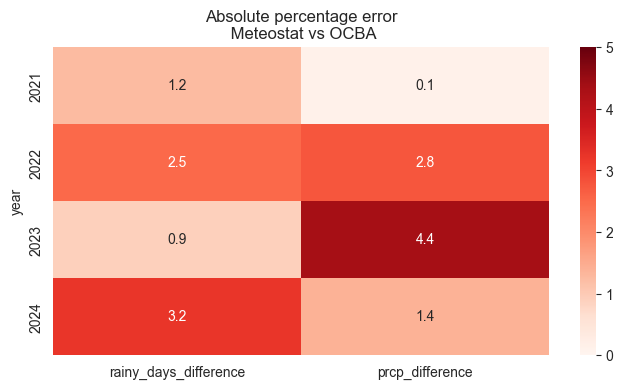

In [487]:
plt.figure(figsize=(8,4))
df_abs = df_merge.abs()
sns.heatmap(
    df_abs.set_index('year')[['rainy_days_difference', 'prcp_difference']],
    annot=True, fmt='.1f', cmap='Reds', vmin=0,vmax=5)
plt.title('Absolute percentage error\n Meteostat vs OCBA')
plt.show()

As can be observed both analytically and graphically, the absolute relative error does not exceed 5% in any case, which justifies replacing NaN values with 0 mm.

In [ ]:
df['prcp'] = df['prcp'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1827 non-null   datetime64[ns]
 1   tavg       1827 non-null   float64       
 2   tmin       1827 non-null   float64       
 3   tmax       1827 non-null   float64       
 4   prcp       1827 non-null   float64       
 5   year       1827 non-null   int32         
 6   rainy_day  1827 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(4), int32(1)
memory usage: 80.4 KB


## Outlier Detection

The appearance of outliers can affect the final conclusions of the analysis, so we proceed to detect
possible atypical values in both a graphical and analytical manner.

Given that the nature of a precipitation time series has an extremely high level of days with prcp = 0, the distribution
is not normal, is considerably asymmetric and has a long tail, only the data with precipitation will be analyzed.

Values above the 99.5 percentile

            date   prcp
731  2022-11-14   90.5
1215 2024-03-12  127.0
1646 2025-05-17   98.0

Negative precipitations

 Empty DataFrame
Columns: [date, prcp]
Index: []


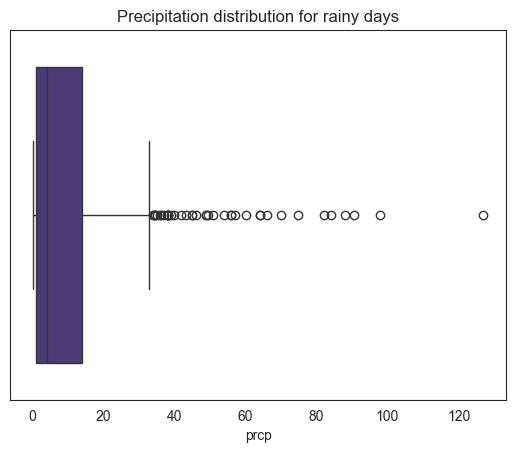

In [ ]:
sns.boxplot(x=df[df['rainy_day'] == True]['prcp'])
plt.title('Precipitation distribution for rainy days')

#Values above the 99.5 percentile
p995 = df[df['rainy_day'] == True]['prcp'].quantile(0.995)
df_outliers = df.loc[df['prcp'] > p995, ['date', 'prcp']]
df_neg = df.loc[df['prcp'] < 0, ['date','prcp']]

print(f'Values above the 99.5 percentile\n\n {df_outliers}\n')
print(f'Negative precipitations\n\n {df_neg}')



What conclusions can be drawn from the results obtained?
When analyzing a meteorological variable such as precipitation, typical values may be days of heavy rainfall rather than errors.
In this case, the three detected days were compared with the SMN records on the ogimet.com site, finding the same values.

Inevitably erroneous values would, in this case, be negative values or values greater than 300 mm, double the historical daily record in Buenos Aires.
In this analysis, none of these two types of errors have been found.

## Dataset transformation

Fields are created to discriminate records by type of day of the week:

day_of_week indicates the weekday number, starting from index 0 (Monday)

is_weekend is a boolean variable that returns True for Friday, Saturday, and Sunday

In [ ]:
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week']>3
df.head()

,date,tavg,tmin,tmax,prcp,year,rainy_day,day_of_week,is_weekend
0,2020-11-13,22.2,19.2,26.6,0.0,2020,False,4,True
1,2020-11-14,22.2,19.3,26.6,0.0,2020,False,5,True
2,2020-11-15,20.9,15.7,26.0,0.0,2020,False,6,True
3,2020-11-16,20.5,14.0,26.3,0.0,2020,False,0,False
4,2020-11-17,23.4,17.7,27.7,0.0,2020,False,1,False


## Hypothesis testing

It's time to test our two questions:

1) Is there really a higher probability of rain on the weekend than on the rest of the days?

2) On average, does it rain more on the weekend than on the rest of the days?

Let's start by grouping our data and examining the results.

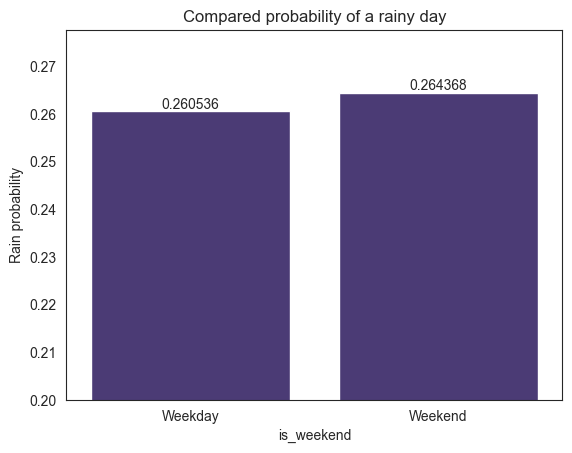

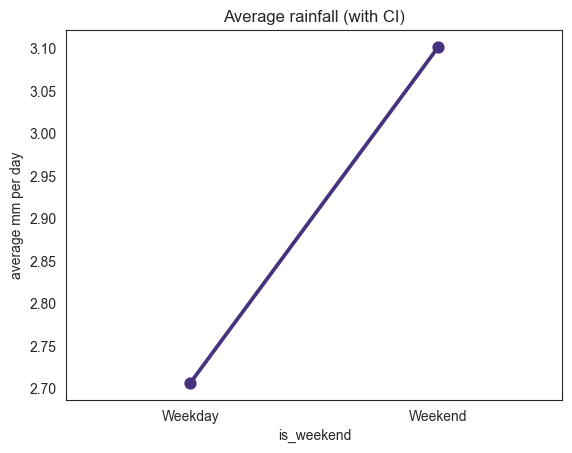

,prcp,rainy_days,total_days
is_weekend,,,
False,2.706418,0.260536,1044
True,3.101660,0.264368,783


In [ ]:
prcp_by_weekday = df.groupby('is_weekend').agg(
    prcp = ('prcp', 'mean'),
    rainy_days = ('rainy_day', 'mean'),
    total_days = ('is_weekend', 'count')
)


ax = sns.barplot(
    data=prcp_by_weekday.reset_index(),
    x="is_weekend",
    y="rainy_days"
)
ax.set_ylim(bottom=0.20)
ax.bar_label(ax.containers[0])
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.ylabel("Rain probability")
plt.title("Compared probability of a rainy day")
plt.show()

sns.pointplot(
    data=prcp_by_weekday.reset_index(),
    x="is_weekend",
    y="prcp",
    capsize=0.2
)
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.ylabel("average mm per day")
plt.title("Average rainfall (with CI)")
plt.show()

prcp_by_weekday


## Is there really a higher probability of rain on the weekend than on the rest of the days?

We can observe that, in Buenos Aires, it rained on 26.44% of weekend days compared to 26.05% of the rest of the weekdays over the last 5 years.

Although the percentage difference seems small, we want to determine whether this is statistically significant.

To do so, we will perform the well-known two-proportion Z-test, which evaluates a test of two proportions: whether there is a significant difference in success rates between two independent groups.
In our case, the groups are weekend (Fri-Sun) and weekdays (Mon-Thu).

Statements:

Null Hypothesis (H0): The proportion of rainy days is the same for weekends and weekdays.

Alternative Hypothesis (H1): The proportion of rainy days differs between weekends and weekdays.

We will begin the test by creating Boolean series determining whether it is a rainy and weekday (rain_weekday) or rainy and weekend (rain_weekend)

In [ ]:
rain_weekday = df[df['is_weekend'] == False]['rainy_day']
rain_weekend = df[df['is_weekend'] == True]['rainy_day']

count = [rain_weekend.sum(), rain_weekday.sum()]  #number of successes (rain) for both groups
nobs = [len(rain_weekend), len(rain_weekday)]     #number of days in each group

z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
print('p-value for the Z-test:', p_value)


p-value for the Z-test: 0.8538041244079058


The p-value is the probability of obtaining the results observed in a study, assuming that the null hypothesis is true. To reject the null hypothesis, 
the p-value must be less than or equal to 0.05. In this case, a p-value of 0.8538 means there is an 85.38% chance of observing this difference in proportions if H0 is true.
In other words, **there is no evidence to reject H0, so we cannot conclude that the proportion of rainy days differs between weekdays and weekends.**

## Is there any difference in daily precipitation between the weekend and the rest of the days?

To answer this question, we will compare the precipitation distributions between the two groups.
Given the nature of a precipitation distribution (previously explained), the Mann-Whitney U test is used.

This non-parametric test (does not assume normality) is indicated for data with an abundance of zeros and long tails.

In this case, we state:

Null Hypothesis (H₀): There is no difference in the daily precipitation distribution between weekends and weekdays.

Alternative Hypothesis (H₁): There is a difference in the daily precipitation distribution between both groups.

In [ ]:
#We create the x and y series to separate precipitations into the two groups
x = df[df["is_weekend"] == False]["prcp"]  #weekdays
y = df[df["is_weekend"] == True]["prcp"]   #weekends

#Test
u_stat, p_value = mannwhitneyu(x, y, alternative='two-sided')

print("p-value:", p_value)

p-value: 0.61690366009889


With a p-value of 0.6170, we cannot reject H₀. That is, **there is no evidence that the difference in daily precipitation between weekdays and weekends is statistically significant.**

## General Conclusions

In this analysis, we asked whether there is truly a greater chance of rain on the weekend than during the workweek.

To make the study more robust, we also wanted to see whether there was a difference in the intensity of rain between the two groups of days.

To answer these questions, we followed the classic processes of exploratory data analysis, such as variable analysis, outlier detection and its context, 
handling of missing data, and selection of relevant variables.

Then, we formally stated our hypotheses and performed the percentile statistical test.
**In this case, both hypotheses were raised for both cases, so the differences found between the two groups are not significant and 
are due to the natural variability of the climate for the period 2020-2025 in Buenos Aires.**

We can say that the perception that it rains more likely when the weekend arrives responds more to a cognitive bias (the rainy days that affect our days off from work are not more significant)
than to a climatological pattern.